Detected numeric columns: ['Age', 'Creatinine_Level', 'BUN', 'Diabetes', 'Hypertension', 'GFR', 'Urine_Output', 'CKD_Status', 'Dialysis_Needed']
Detected categorical columns: []
Label column: None
Shapes -> X_train: (1843, 9) X_test: (461, 9)
Recon MSE - AE: 0.0055378103
Recon MSE - VAE: 0.9976471
Recon MSE - HSEN: 0.14937343
Clustering - AE  : {'silhouette': np.float32(0.21481544), 'ari': nan, 'nmi': nan, 'stability_nmi': 1.0}
Clustering - VAE : {'silhouette': np.float32(0.11674291), 'ari': nan, 'nmi': nan, 'stability_nmi': 0.9546956819974584}
Clustering - HSEN: {'silhouette': np.float32(0.1371672), 'ari': nan, 'nmi': nan, 'stability_nmi': 0.9682825630627665}
Trustworthiness  AE/VAE/HSEN: 0.9960231381055676 0.6867478788027338 0.9970591239056992
Continuity       AE/VAE/HSEN: 0.8288141720896602 0.1429862617498192 0.866232827187274


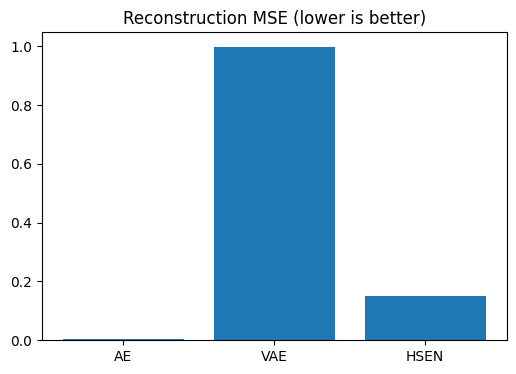

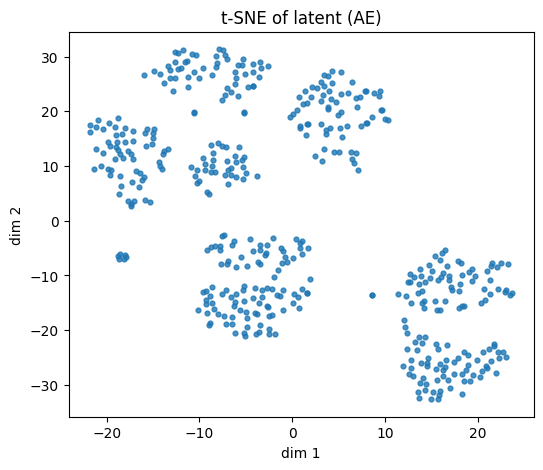

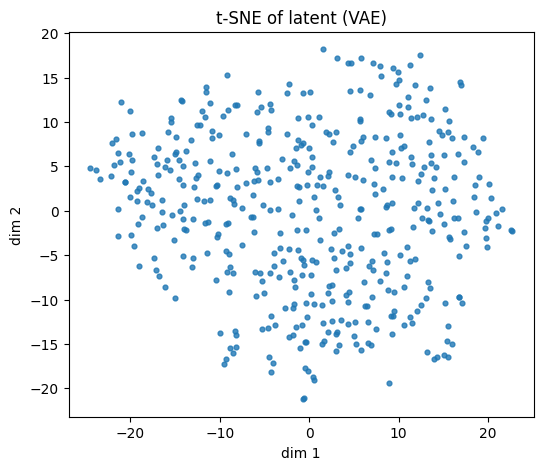

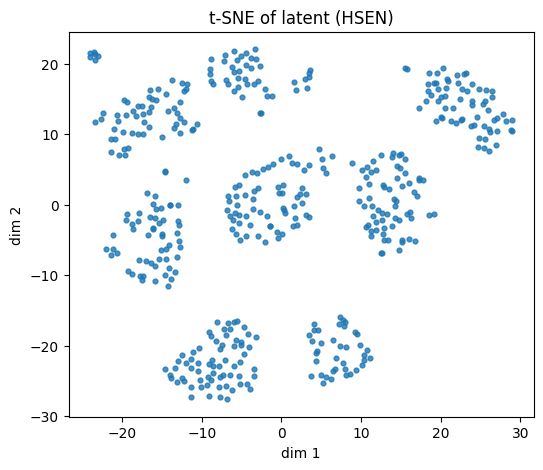

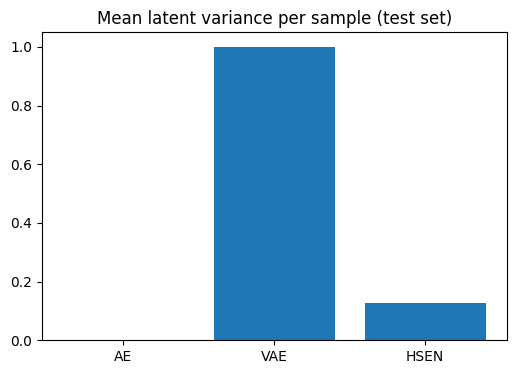

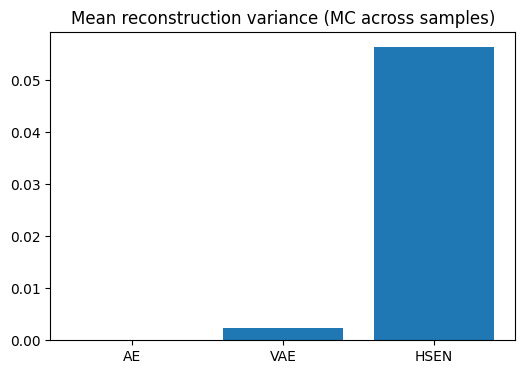

                Model  Recon MSE  Trustworthiness  Continuity  Silhouette  \
0  AE (deterministic)   0.005538         0.996023    0.828814    0.214815   
1                 VAE   0.997647         0.686748    0.142986    0.116743   
2     HSEN (proposed)   0.149373         0.997059    0.866233    0.137167   

   ARI  NMI  Stability (NMI)  
0  NaN  NaN         1.000000  
1  NaN  NaN         0.954696  
2  NaN  NaN         0.968283  
Saved metrics to hsen_vae_ae_results.csv


In [ ]:
# ================================
# Non-Deterministic Unsupervised Neural Network Model
# HSEN (proposed) vs VAE (baseline) vs AE (deterministic)
# ================================

# 0) Imports & Utilities
import os, math, random, numpy as np, pandas as pd
from typing import Tuple
from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import trustworthiness
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DATA_PATH = '/content/kidney_disease_dataset.csv'

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ================================
# 1) Data Loading & Preprocessing
# ================================
# 1.1 Load
df = pd.read_csv(DATA_PATH)

# Try to detect a label column if present
label_candidates = [c for c in df.columns if c.lower() in ['classification','class','label','target','y']]
label_col = label_candidates[0] if len(label_candidates) > 0 else None
y = df[label_col].values if label_col else None

# 1.2 Basic cleaning: strip spaces, robust numeric conversion
df = df.rename(columns=lambda c: c.strip())
for col in df.columns:
    if col == label_col:
        continue
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        pass

# 1.3 Identify categorical vs numeric
cat_cols = [c for c in df.columns if c != label_col and df[c].dtype == 'object']
num_cols = [c for c in df.columns if c != label_col and pd.api.types.is_numeric_dtype(df[c])]

# 1.4 Fill missing values
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    mode_vals = df[c].mode()
    df[c] = df[c].fillna(mode_vals[0] if len(mode_vals) > 0 else 'missing')

# 1.5 Encode label if categorical
if label_col is not None and df[label_col].dtype == 'object':
    y = pd.Categorical(df[label_col]).codes
elif label_col is not None:
    y = df[label_col].values

X = df.drop(columns=[label_col]) if label_col else df.copy()

# 1.6 Preprocess pipeline
transformers = []
if len(num_cols) > 0:
    transformers.append(('num', Pipeline([('sc', StandardScaler())]), num_cols))
if len(cat_cols) > 0:
    transformers.append(('cat', Pipeline([('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols))
if not transformers:
    raise ValueError("No usable numeric or categorical columns found after cleaning. Inspect dataset.")

pre = ColumnTransformer(transformers)
X_proc = pre.fit_transform(X).astype(np.float32)

# 1.7 Train/Test split
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_proc, y, test_size=0.2, random_state=SEED,
        stratify=y if (y is not None) else None
    )
else:
    X_train, X_test = train_test_split(
        X_proc, test_size=0.2, random_state=SEED
    )
    y_train, y_test = None, None

print("Detected numeric columns:", num_cols)
print("Detected categorical columns:", cat_cols)
print("Label column:", label_col)
print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

# 1.8 Torch dataset & loaders
class NpDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(np.asarray(X)).float()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx]

BATCH = 256
train_ds = NpDataset(X_train)
test_ds  = NpDataset(X_test)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

INPUT_DIM  = X_train.shape[1]
LATENT_DIM = 8

# ================================
# 2) Models (+ Init)
# ================================
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, act=nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), act(),
            nn.Linear(d_hidden, d_hidden), act(),
            nn.Linear(d_hidden, d_out)
        )
    def forward(self, x):
        return self.net(x)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

# --- Encoder/Decoder for stochastic models ---
class Encoder(nn.Module):
    def __init__(self, d_in, d_hidden, d_latent):
        super().__init__()
        self.backbone = MLP(d_in, d_hidden, 2*d_latent)  # [mu | logvar]
    def forward(self, x):
        h = self.backbone(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        logvar = torch.clamp(logvar, -8.0, 8.0)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, d_latent, d_hidden, d_out):
        super().__init__()
        self.backbone = MLP(d_latent, d_hidden, d_out, act=nn.ReLU)
    def forward(self, z):
        return self.backbone(z)

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std, std

# --- Deterministic Autoencoder (AE) ---
class AE(nn.Module):
    def __init__(self, d_in, d_hidden, d_latent):
        super().__init__()
        self.enc_core = MLP(d_in, d_hidden, d_latent)
        self.dec      = MLP(d_latent, d_hidden, d_in)
    def encode(self, x):
        return self.enc_core(x)
    def forward(self, x):
        z = self.encode(x)
        xhat = self.dec(z)
        return xhat, z

# --- VAE  ---
class VAE(nn.Module):
    def __init__(self, d_in, d_hidden, d_latent, beta=1.0):
        super().__init__()
        self.enc = Encoder(d_in, d_hidden, d_latent)
        self.dec = Decoder(d_latent, d_hidden, d_in)
        self.beta = beta
    def forward(self, x):
        mu, logvar = self.enc(x)
        z, std = reparameterize(mu, logvar)
        xhat = self.dec(z)
        return xhat, mu, logvar, z, std

# --- HSEN (proposed) ---
class HSEN(nn.Module):
    def __init__(self, d_in, d_hidden, d_latent, lambda_kl=0.1, lambda_stab=0.1):
        super().__init__()
        self.enc = Encoder(d_in, d_hidden, d_latent)
        self.dec = Decoder(d_latent, d_hidden, d_in)
        self.lambda_kl = lambda_kl
        self.lambda_stab = lambda_stab
    def forward(self, x):
        mu, logvar = self.enc(x)
        z1, _ = reparameterize(mu, logvar)
        z2, _ = reparameterize(mu, logvar)
        xhat1 = self.dec(z1)
        xhat2 = self.dec(z2)
        return (xhat1, xhat2), mu, logvar, (z1, z2)

# --- Losses ---
def mse_loss(x, xhat):
    return F.mse_loss(xhat, x, reduction='mean')

def kl_standard_normal(mu, logvar):
    return 0.5 * torch.mean(torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=-1))

def stability_loss(z1, z2):
    return torch.mean(torch.sum((z1 - z2)**2, dim=-1))

# ================================
# 3) Training
# ================================
@dataclass
class TrainCfg:
    d_hidden:int=128
    d_latent:int=8
    lr:float=1e-3
    epochs:int=30
    beta:float=1.0
    lambda_kl:float=0.1
    lambda_stab:float=0.1
    patience:int=8

def train_ae(d_hidden=128, d_latent=8, lr=1e-3, epochs=30, patience=8):
    model = AE(INPUT_DIM, d_hidden, d_latent).to(DEVICE)
    model.apply(init_weights)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float('inf'); wait=0; best_state=None

    for ep in range(epochs):
        model.train(); losses=[]
        for xb in train_loader:
            xb = xb.to(DEVICE)
            xhat, _ = model(xb)
            loss = F.mse_loss(xhat, xb)
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
        # early stop on test set
        model.eval(); vls=[]
        with torch.no_grad():
            for xb in test_loader:
                xb = xb.to(DEVICE)
                xhat, _ = model(xb)
                vls.append(F.mse_loss(xhat, xb).item())
        val_loss = float(np.mean(vls))
        if val_loss < best_val:
            best_val = val_loss; wait=0; best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience: break
    if best_state is not None: model.load_state_dict(best_state)
    return model

def train_vae(cfg: TrainCfg):
    model = VAE(INPUT_DIM, cfg.d_hidden, cfg.d_latent, beta=cfg.beta).to(DEVICE)
    model.apply(init_weights)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    best_val = float('inf'); wait=0; best_state=None

    for ep in range(cfg.epochs):
        model.train(); losses=[]
        for xb in train_loader:
            xb = xb.to(DEVICE)
            xhat, mu, logvar, _, _ = model(xb)
            rec = mse_loss(xb, xhat)
            kld = kl_standard_normal(mu, logvar)
            loss = rec + cfg.beta * kld
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
        # val
        model.eval(); vls=[]
        with torch.no_grad():
            for xb in test_loader:
                xb = xb.to(DEVICE)
                xhat, mu, logvar, *_ = model(xb)
                rec = mse_loss(xb, xhat)
                kld = kl_standard_normal(mu, logvar)
                vls.append((rec + cfg.beta*kld).item())
        val_loss = float(np.mean(vls))
        if val_loss < best_val:
            best_val = val_loss; wait=0; best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= cfg.patience: break
    if best_state is not None: model.load_state_dict(best_state)
    return model

def train_hsen(cfg: TrainCfg):
    model = HSEN(INPUT_DIM, cfg.d_hidden, cfg.d_latent, lambda_kl=cfg.lambda_kl, lambda_stab=cfg.lambda_stab).to(DEVICE)
    model.apply(init_weights)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    best_val = float('inf'); wait=0; best_state=None

    for ep in range(cfg.epochs):
        model.train(); losses=[]
        for xb in train_loader:
            xb = xb.to(DEVICE)
            (xhat1, xhat2), mu, logvar, (z1, z2) = model(xb)
            rec = 0.5*(mse_loss(xb, xhat1) + mse_loss(xb, xhat2))
            kld = kl_standard_normal(mu, logvar)
            stab = stability_loss(z1, z2)
            loss = rec + cfg.lambda_kl*kld + cfg.lambda_stab*stab
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
        # val
        model.eval(); vls=[]
        with torch.no_grad():
            for xb in test_loader:
                xb = xb.to(DEVICE)
                (xhat1, xhat2), mu, logvar, (z1, z2) = model(xb)
                rec = 0.5*(mse_loss(xb, xhat1) + mse_loss(xb, xhat2))
                kld = kl_standard_normal(mu, logvar)
                stab = stability_loss(z1, z2)
                vls.append((rec + cfg.lambda_kl*kld + cfg.lambda_stab*stab).item())
        val_loss = float(np.mean(vls))
        if val_loss < best_val:
            best_val = val_loss; wait=0; best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= cfg.patience: break
    if best_state is not None: model.load_state_dict(best_state)
    return model

# ================================
# 4) Fit Models
# ================================
cfg = TrainCfg(epochs=30, d_hidden=128, d_latent=LATENT_DIM, lr=1e-3, beta=1.0, lambda_kl=0.1, lambda_stab=0.1)
set_seed(SEED)

ae   = train_ae(d_hidden=128, d_latent=LATENT_DIM, lr=1e-3, epochs=30, patience=8)
vae  = train_vae(cfg)
hsen = train_hsen(cfg)

# ================================
# 5) Embeddings, Reconstructions & Uncertainty
# ================================
@torch.no_grad()
def get_embeddings_ae(model, loader):
    model.eval()
    Zs, Xs, Xhats = [], [], []
    for xb in loader:
        xb = xb.to(DEVICE)
        xhat, z = model(xb)
        Zs.append(z.cpu().numpy())
        Xs.append(xb.cpu().numpy())
        Xhats.append(xhat.cpu().numpy())
    Z = np.vstack(Zs); X = np.vstack(Xs); Xhat = np.vstack(Xhats)
    Zvar = np.zeros_like(Z)       # deterministic
    RecVar = np.zeros_like(Xhat)  # deterministic
    return Z, Zvar, X, Xhat, RecVar

@torch.no_grad()
def get_embeddings(model, loader, kind='vae', n_samples=5):
    model.eval()
    zs, xs, xhats, zvars = [], [], [], []
    for xb in loader:
        xb = xb.to(DEVICE)
        if kind == 'vae':
            xhat, mu, logvar, z, std = model(xb)
            zs.append(mu.cpu().numpy())
            xs.append(xb.cpu().numpy())
            xhats.append(xhat.cpu().numpy())
            zvars.append(torch.exp(logvar).cpu().numpy())
        else:  # hsen
            (xhat1, xhat2), mu, logvar, (z1, z2) = model(xb)
            zs.append(mu.cpu().numpy())
            xs.append(xb.cpu().numpy())
            xhats.append(0.5*(xhat1 + xhat2).cpu().numpy())
            zvars.append(torch.exp(logvar).cpu().numpy())
    Z = np.vstack(zs); X = np.vstack(xs); Xhat = np.vstack(xhats); Zvar = np.vstack(zvars)

    rec_vars = []
    for xb in loader:
        xb = xb.to(DEVICE)
        rec_samples = []
        for _ in range(n_samples):
            if kind == 'vae':
                xhat, *_ = model(xb)
            else:
                (xhat1, xhat2), *_ = model(xb)
                xhat = 0.5*(xhat1 + xhat2)
            rec_samples.append(xhat.cpu().numpy())
        R = np.stack(rec_samples, axis=0)
        rec_vars.append(np.var(R, axis=0))
    RecVar = np.vstack(rec_vars)
    return Z, Zvar, X, Xhat, RecVar

# AE
Z_ae, Zvar_ae, X_te, Xhat_ae, RecVar_ae = get_embeddings_ae(ae, test_loader)
mse_ae = np.mean((X_te - Xhat_ae)**2)
print("Recon MSE - AE:", mse_ae)

# VAE
Z_vae, Zvar_vae, _, Xhat_vae, RecVar_vae = get_embeddings(vae, test_loader, kind='vae')
mse_vae = np.mean((X_te - Xhat_vae)**2)
print("Recon MSE - VAE:", mse_vae)

# HSEN
Z_hsen, Zvar_hsen, _, Xhat_hsen, RecVar_hsen = get_embeddings(hsen, test_loader, kind='hsen')
mse_hsen = np.mean((X_te - Xhat_hsen)**2)
print("Recon MSE - HSEN:", mse_hsen)

# ================================
# 6) Clustering Metrics (+ stability)
# ================================
def clustering_eval(Z, y_true=None, n_clusters=2, seeds=[0,1,2,3,4]):
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=SEED)
    labels = km.fit_predict(Z)
    sil = silhouette_score(Z, labels) if len(np.unique(labels)) > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else np.nan
    nmi = normalized_mutual_info_score(y_true, labels) if y_true is not None else np.nan

    runs = []
    for s in seeds:
        km = KMeans(n_clusters=n_clusters, n_init=10, random_state=s)
        runs.append(km.fit_predict(Z))
    from itertools import combinations
    pair_nmis = [normalized_mutual_info_score(runs[a], runs[b]) for a,b in combinations(range(len(runs)), 2)]
    stab = float(np.mean(pair_nmis)) if pair_nmis else np.nan
    return {'silhouette': sil, 'ari': ari, 'nmi': nmi, 'stability_nmi': stab}, labels

if y_test is not None:
    n_cls = max(len(np.unique(y_test)), 2)
else:
    n_cls = 3

metrics_ae, labels_ae   = clustering_eval(Z_ae,   y_true=y_test if y_test is not None else None, n_clusters=n_cls)
metrics_vae, labels_vae = clustering_eval(Z_vae,  y_true=y_test if y_test is not None else None, n_clusters=n_cls)
metrics_hsen, labels_hsen = clustering_eval(Z_hsen, y_true=y_test if y_test is not None else None, n_clusters=n_cls)

print("Clustering - AE  :", metrics_ae)
print("Clustering - VAE :", metrics_vae)
print("Clustering - HSEN:", metrics_hsen)

# ================================
# 7) Dimensionality Reduction Metrics
# ================================
def knn_graph(X, k=12):
    D = cdist(X, X, metric='euclidean')
    idx = np.argsort(D, axis=1)[:, 1:k+1]
    return idx

def continuity(X, Z, k=12):
    idx_X = knn_graph(X, k=k)
    idx_Z = knn_graph(Z, k=k)
    n = X.shape[0]
    scores = []
    for i in range(n):
        set_X = set(idx_X[i]); set_Z = set(idx_Z[i])
        scores.append(len(set_X & set_Z) / float(k))
    return float(np.mean(scores))

# AE
tw_ae  = trustworthiness(X_te, Z_ae, n_neighbors=12)
cont_ae = continuity(X_te, Z_ae, k=12)

# VAE
tw_vae  = trustworthiness(X_te, Z_vae, n_neighbors=12)
cont_vae = continuity(X_te, Z_vae, k=12)

# HSEN
tw_hsen  = trustworthiness(X_te, Z_hsen, n_neighbors=12)
cont_hsen = continuity(X_te, Z_hsen, k=12)

print("Trustworthiness  AE/VAE/HSEN:", tw_ae, tw_vae, tw_hsen)
print("Continuity       AE/VAE/HSEN:", cont_ae, cont_vae, cont_hsen)

# ================================
# 8) Visualization
# ================================
# Recon MSE bar
plt.figure(figsize=(6,4))
plt.title('Reconstruction MSE (lower is better)')
plt.bar(['AE','VAE','HSEN'], [
    float(np.mean((X_te - Xhat_ae )**2)),
    float(np.mean((X_te - Xhat_vae)**2)),
    float(np.mean((X_te - Xhat_hsen)**2))
])
plt.show()

# t-SNE (latent means for all three)
tsne_ae   = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=SEED).fit_transform(Z_ae)
tsne_vae  = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=SEED).fit_transform(Z_vae)
tsne_hsen = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=SEED).fit_transform(Z_hsen)

def scatter_2d(A, title, y=None):
    plt.figure(figsize=(6,5))
    plt.title(title)
    if y is not None:
        plt.scatter(A[:,0], A[:,1], c=y, s=12, alpha=0.8, cmap='tab10')
    else:
        plt.scatter(A[:,0], A[:,1], s=12, alpha=0.8)
    plt.xlabel('dim 1'); plt.ylabel('dim 2'); plt.show()

scatter_2d(tsne_ae,   't-SNE of latent (AE)',   y_test if y_test is not None else None)
scatter_2d(tsne_vae,  't-SNE of latent (VAE)',  y_test if y_test is not None else None)
scatter_2d(tsne_hsen, 't-SNE of latent (HSEN)', y_test if y_test is not None else None)

# Uncertainty summaries (latent var & recon var) — AE is 0 by design
plt.figure(figsize=(6,4))
plt.title('Mean latent variance per sample (test set)')
plt.bar(['AE','VAE','HSEN'], [
    float(np.mean(Zvar_ae)),
    float(np.mean(Zvar_vae)),
    float(np.mean(Zvar_hsen))
])
plt.show()

plt.figure(figsize=(6,4))
plt.title('Mean reconstruction variance (MC across samples)')
plt.bar(['AE','VAE','HSEN'], [
    float(np.mean(RecVar_ae)),
    float(np.mean(RecVar_vae)),
    float(np.mean(RecVar_hsen))
])
plt.show()

# ================================
# 9) Results Table
# ================================
rows = []
rows.append({
    'Model':'AE (deterministic)',
    'Recon MSE': float(np.mean((X_te - Xhat_ae)**2)),
    'Trustworthiness': float(tw_ae),
    'Continuity': float(cont_ae),
    'Silhouette': float(metrics_ae['silhouette']),
    'ARI': float('nan' if (metrics_ae['ari'] is np.nan or metrics_ae['ari'] is None) else metrics_ae['ari']),
    'NMI': float('nan' if (metrics_ae['nmi'] is np.nan or metrics_ae['nmi'] is None) else metrics_ae['nmi']),
    'Stability (NMI)': float(metrics_ae['stability_nmi'])
})
rows.append({
    'Model':'VAE',
    'Recon MSE': float(np.mean((X_te - Xhat_vae)**2)),
    'Trustworthiness': float(tw_vae),
    'Continuity': float(cont_vae),
    'Silhouette': float(metrics_vae['silhouette']),
    'ARI': float('nan' if (metrics_vae['ari'] is np.nan or metrics_vae['ari'] is None) else metrics_vae['ari']),
    'NMI': float('nan' if (metrics_vae['nmi'] is np.nan or metrics_vae['nmi'] is None) else metrics_vae['nmi']),
    'Stability (NMI)': float(metrics_vae['stability_nmi'])
})
rows.append({
    'Model':'HSEN (proposed)',
    'Recon MSE': float(np.mean((X_te - Xhat_hsen)**2)),
    'Trustworthiness': float(tw_hsen),
    'Continuity': float(cont_hsen),
    'Silhouette': float(metrics_hsen['silhouette']),
    'ARI': float('nan' if (metrics_hsen['ari'] is np.nan or metrics_hsen['ari'] is None) else metrics_hsen['ari']),
    'NMI': float('nan' if (metrics_hsen['nmi'] is np.nan or metrics_hsen['nmi'] is None) else metrics_hsen['nmi']),
    'Stability (NMI)': float(metrics_hsen['stability_nmi'])
})
results_df = pd.DataFrame(rows)
print(results_df)

# Optional: save outputs for report
results_df.to_csv('hsen_vae_ae_results.csv', index=False)
np.save('tsne_ae.npy', tsne_ae); np.save('tsne_vae.npy', tsne_vae); np.save('tsne_hsen.npy', tsne_hsen)
print("Saved metrics to hsen_vae_ae_results.csv")
